<font size = 5>
Importing Libraries

In [134]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_ta as ta
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, validation_curve, GridSearchCV, train_test_split

In [193]:
def apply_strategy(dataframe, target_col, name):
    
    # Create Long/Short columns
    dataframe["Long"] = np.zeros(len(target_col))
    dataframe["LongPct"] = np.zeros(len(target_col))
    dataframe["Short"] = np.zeros(len(target_col))
    dataframe["ShortPct"] = np.zeros(len(target_col))
    dataframe["TotEquity"] = np.zeros(len(target_col))
    dataframe["LongEquity"] = np.zeros(len(target_col))
    dataframe["ShortEquity"] = np.zeros(len(target_col))
    
    # Fill Long/Short columns (1 if Long/Short is open, 0 if it's not, based on target_col prediction)
    
    for i, num in enumerate(target_col):
        try:    
            if num == 1:
                dataframe.Long[i+1] = 1
                dataframe.Short[i+1] = 0
            else:
                dataframe.Long[i+1] = 0
                dataframe.Short[i+1] = 1
        except IndexError:
            break
    
    for i, num in enumerate(dataframe.Long):
        if num == 1:
            dataframe.LongPct[i] = (dataframe.Close[i] - dataframe.Open[i])/dataframe.Open[i]
        else:
            dataframe.LongPct[i] = 0
    for i, num in enumerate(dataframe.Short):
        if num == 1:
            dataframe.ShortPct[i] = ((dataframe.Close[i] - dataframe.Open[i])/dataframe.Open[i])*(-1)
        else:
            dataframe.ShortPct[i] = 0
    dataframe["TotReturn"] = (dataframe["LongPct"]+dataframe["ShortPct"])*100
    
    for i in range(len(dataframe.Close)):
        dataframe.LongEquity[i] = np.sum(dataframe.LongPct[:i])
        dataframe.ShortEquity[i] = np.sum(dataframe.ShortPct[:i])
        dataframe.TotEquity[i] = dataframe.LongEquity[i] + dataframe.ShortEquity[i]
    
    # Evaluation metrics
    TotLongPct = sum(dataframe["LongPct"])
    TotShortPct = sum(dataframe["ShortPct"])
    TotReturnPct = round(TotLongPct + TotShortPct, 2)
    AnnualizedReturn = round((TotReturnPct*100)/len(dataframe.index)*365, 2)
    BuyNHoldReturn = round(((dataframe.Close.iloc[-1,] - dataframe.Open.iloc[1,])/dataframe.Open.iloc[1,])*100, 2)
    BenchBuyNHold = round(TotReturnPct*100-BuyNHoldReturn, 2)

    
    
    # Summary output
    
    print(f"-----------Performance-----------{name}")
    print(f"Trading period: {len(dataframe.index)} days")
    print(f"Net Profit: {TotReturnPct*100}%")
    print(f"Annualized avg return: {AnnualizedReturn}%")
    print(f"Buy on 1st day and hold till last day strategy would have returned: {BuyNHoldReturn}%")
    print(f"Result VS buy and hold: {BenchBuyNHold}%")

<font size = 5>
Fetching Data

In [180]:
ibm_train = pd.DataFrame(pdr.DataReader("IBM","yahoo",
                         start = "12-31-1999",
                         end = "01-01-2021"))
ibm_test = pd.DataFrame(pdr.DataReader("IBM", "yahoo",
                        start = "02-01-2021",
                        end = "27-03-2022"))

wti_train = pd.DataFrame(pdr.DataReader("CL=F", "yahoo",
                         start = "12-31-1999",
                         end = "01-01-2021"))
wti_test = pd.DataFrame(pdr.DataReader("CL=F", "yahoo",
                         start = "02-01-2021",
                         end = "27-03-2022"))

gold_train = pd.DataFrame(pdr.DataReader("GC=F", "yahoo",
                     start = "31-12-1999",
                     end = "01-01-2021"))
gold_test = pd.DataFrame(pdr.DataReader("GC=F", "yahoo",
                     start = "02-01-2021",
                     end = "27-03-2022"))

nasdaq_train = pd.DataFrame(pdr.DataReader("^IXIC", "yahoo",
                     start = "31-12-1999",
                     end = "01-01-2021"))
nasdaq_test = pd.DataFrame(pdr.DataReader("^IXIC", "yahoo",
                     start = "02-01-2021",
                     end = "27-03-2022"))

In [181]:
datasets = [ibm_train, ibm_test, wti_train, wti_test, gold_train, gold_test, nasdaq_train, nasdaq_test]
train_sets = [ibm_train, wti_train, gold_train, nasdaq_train]
test_sets = [ibm_test, wti_test, gold_test, nasdaq_test]

In [182]:
for i in datasets:
    i["Close_shifted"] = i["Close"].transform(lambda x: x.shift(+1))
    i["Target"] = np.where(i["Close_shifted"] > i["Close"], 1, 0)
    i.dropna() 

<font size = 5>
Exploratory Data Analysis

<AxesSubplot:>

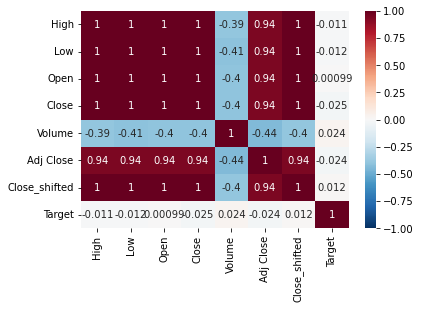

In [183]:
sns.heatmap(ibm_train.corr(),
            cmap = "RdBu_r",
            annot = True,
            vmin = -1,
            vmax = 1)

In [184]:
# keep only uncorrelated vars (close, volume and open as it's needed for the strategy)

cols = ["High", "Low", "Adj Close", "Close_shifted"]
for i in datasets:
    i.drop(cols,
           axis = 1, 
           inplace = True)
    

In [185]:
y = ibm_train["Target"]

In [186]:
x_train, x_test, y_train, y_test = train_test_split(ibm_train, y, test_size=0.05, random_state=24)

In [187]:
rfc=RandomForestClassifier(random_state=24)

In [14]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [23]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=24),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [24]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 200}

In [188]:
rfc1=RandomForestClassifier(random_state = 24,
                            max_features = 'auto',
                            n_estimators = 200,
                            max_depth = 4,
                            criterion = 'gini')


In [189]:
rfc1.fit(x_train, y_train)

RandomForestClassifier(max_depth=4, n_estimators=200, random_state=24)

In [190]:
ibm_test_7 = ibm_test[::7]
wti_test_7 = wti_test[::7]
gold_test_7 = gold_test[::7]
nasdaq_test_7 = nasdaq_test[::7]

ibm_test_14 = ibm_test[::14]
wti_test_14 = wti_test[::14]
gold_test_14 = gold_test[::14]
nasdaq_test_14 = nasdaq_test[::14]

In [191]:
ibm_pred = rfc1.predict(ibm_test)
wti_pred = rfc1.predict(wti_test)
gold_pred = rfc1.predict(gold_test)
nasdaq_pred = rfc1.predict(nasdaq_test)

ibm_pred_7 = rfc1.predict(ibm_test_7)
wti_pred_7 = rfc1.predict(wti_test_7)
gold_pred_7 = rfc1.predict(gold_test_7)
nasdaq_pred_7 = rfc1.predict(nasdaq_test_7)

ibm_pred_14 = rfc1.predict(ibm_test_14)
wti_pred_14 = rfc1.predict(wti_test_14)
gold_pred_14 = rfc1.predict(gold_test_14)
nasdaq_pred_14 = rfc1.predict(nasdaq_test_14)

In [194]:
apply_strategy(ibm_test, ibm_test["Target"], "IBM")
apply_strategy(wti_test, wti_test["Target"], "WTI")
apply_strategy(gold_test, gold_test["Target"], "GOLD")
apply_strategy(nasdaq_test, nasdaq_test["Target"], "NASDAQ")

apply_strategy(ibm_test_7, ibm_test_7["Target"], "IBM7")
apply_strategy(wti_test_7, wti_test_7["Target"], "WTI7")
apply_strategy(gold_test_7, gold_test_7["Target"], "GOLD7")
apply_strategy(nasdaq_test_7, nasdaq_test_7["Target"], "NASDAQ7")

apply_strategy(ibm_test_14, ibm_test_14["Target"], "IBM14")
apply_strategy(wti_test_14, wti_test_14["Target"], "WTI14")
apply_strategy(gold_test_14, gold_test_14["Target"], "GOLD14")
apply_strategy(nasdaq_test_14, nasdaq_test_14["Target"], "NASDAQ14")

-----------Performance-----------IBM
Trading period: 291 days
Net Profit: 8.0%
Annualized avg return: 10.03%
Buy on 1st day and hold till last day strategy would have returned: 15.11%
Result VS buy and hold: -7.11%
-----------Performance-----------WTI
Trading period: 292 days
Net Profit: -2.0%
Annualized avg return: -2.5%
Buy on 1st day and hold till last day strategy would have returned: 112.98%
Result VS buy and hold: -114.98%
-----------Performance-----------GOLD
Trading period: 292 days
Net Profit: -5.0%
Annualized avg return: -6.25%
Buy on 1st day and hold till last day strategy would have returned: 5.07%
Result VS buy and hold: -10.07%
-----------Performance-----------NASDAQ
Trading period: 291 days
Net Profit: 14.000000000000002%
Annualized avg return: 17.56%
Buy on 1st day and hold till last day strategy would have returned: 4.62%
Result VS buy and hold: 9.38%
-----------Performance-----------IBM7
Trading period: 42 days
Net Profit: -10.0%
Annualized avg return: -86.9%
Buy on 1

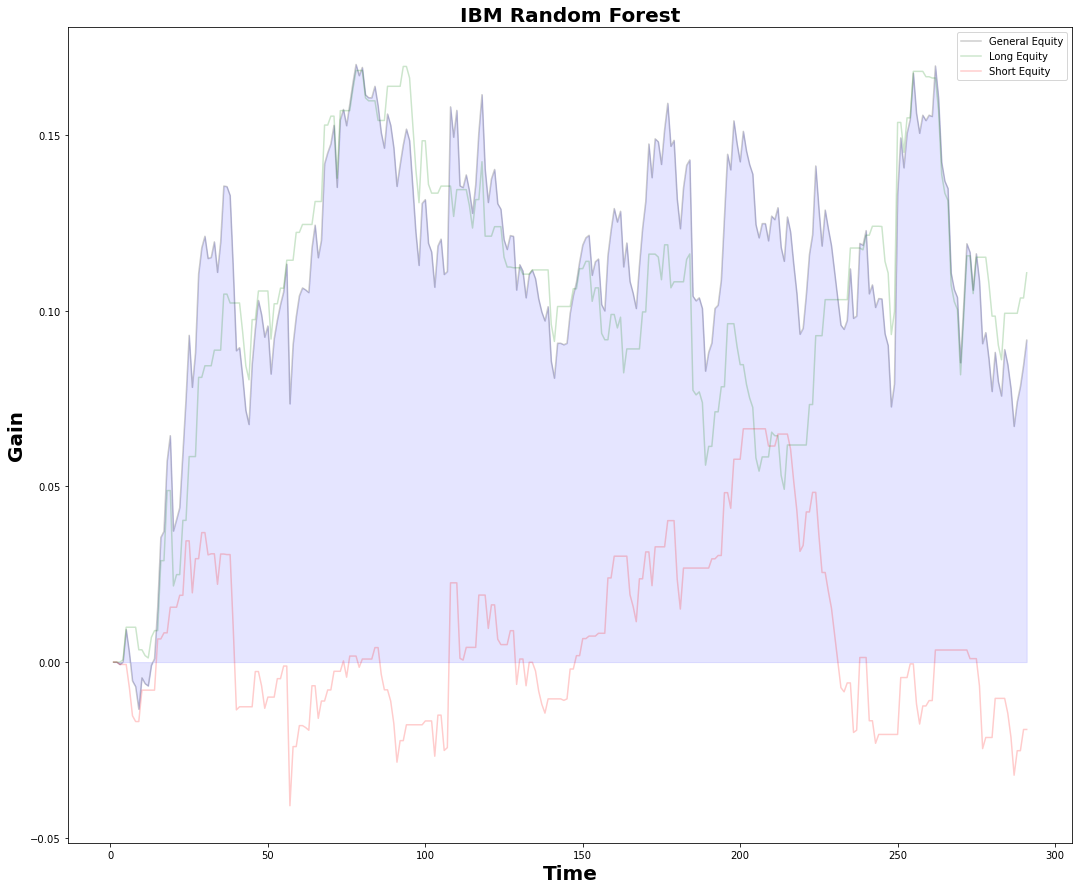

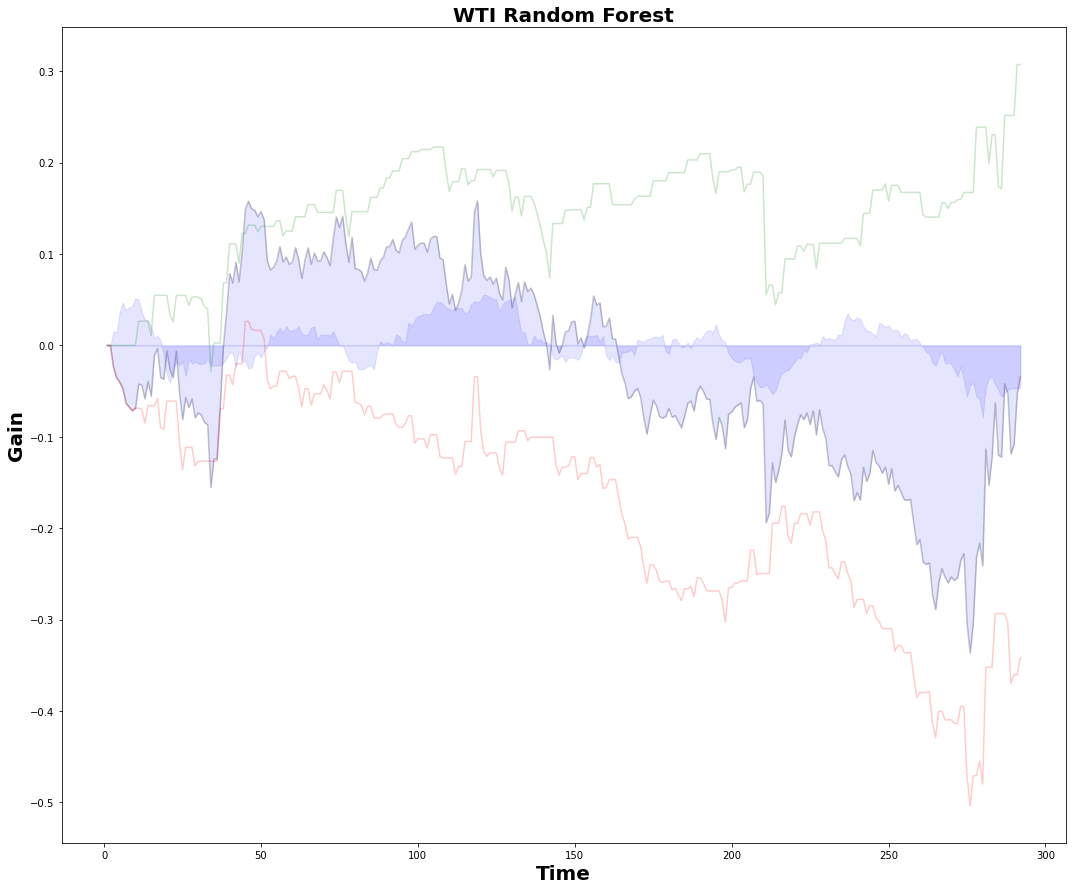

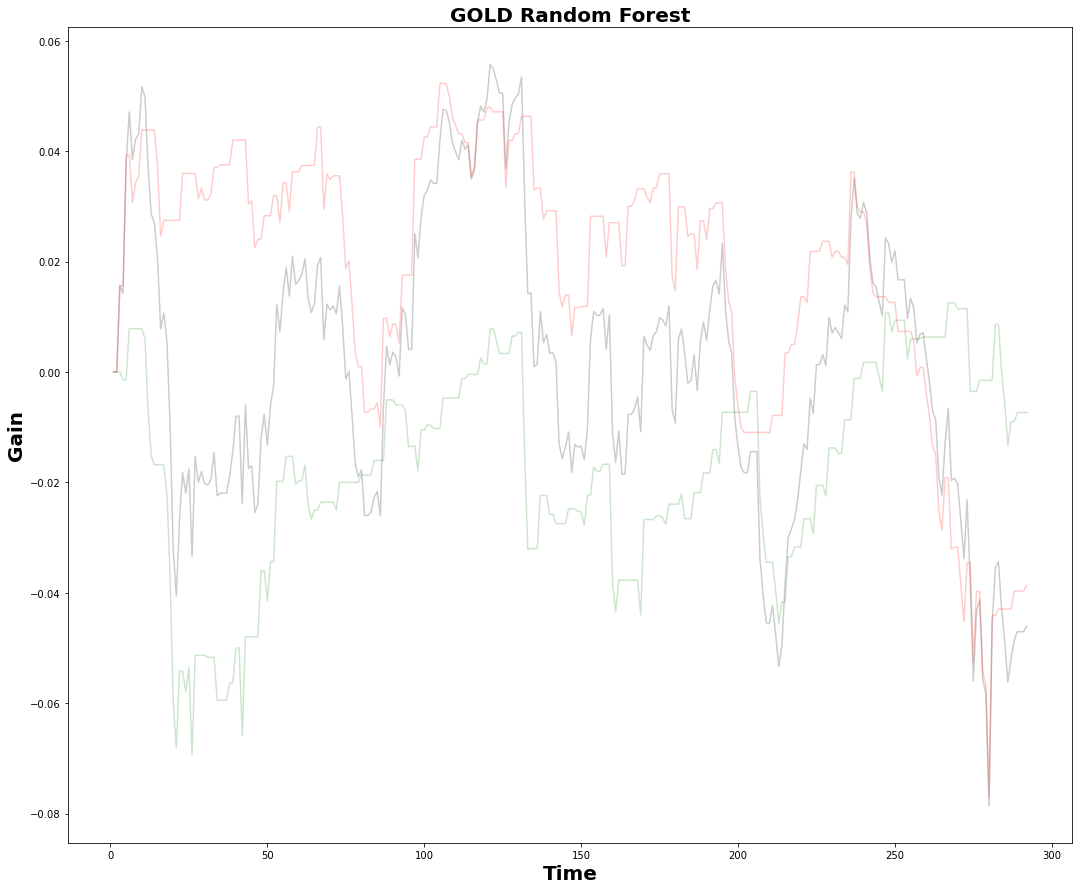

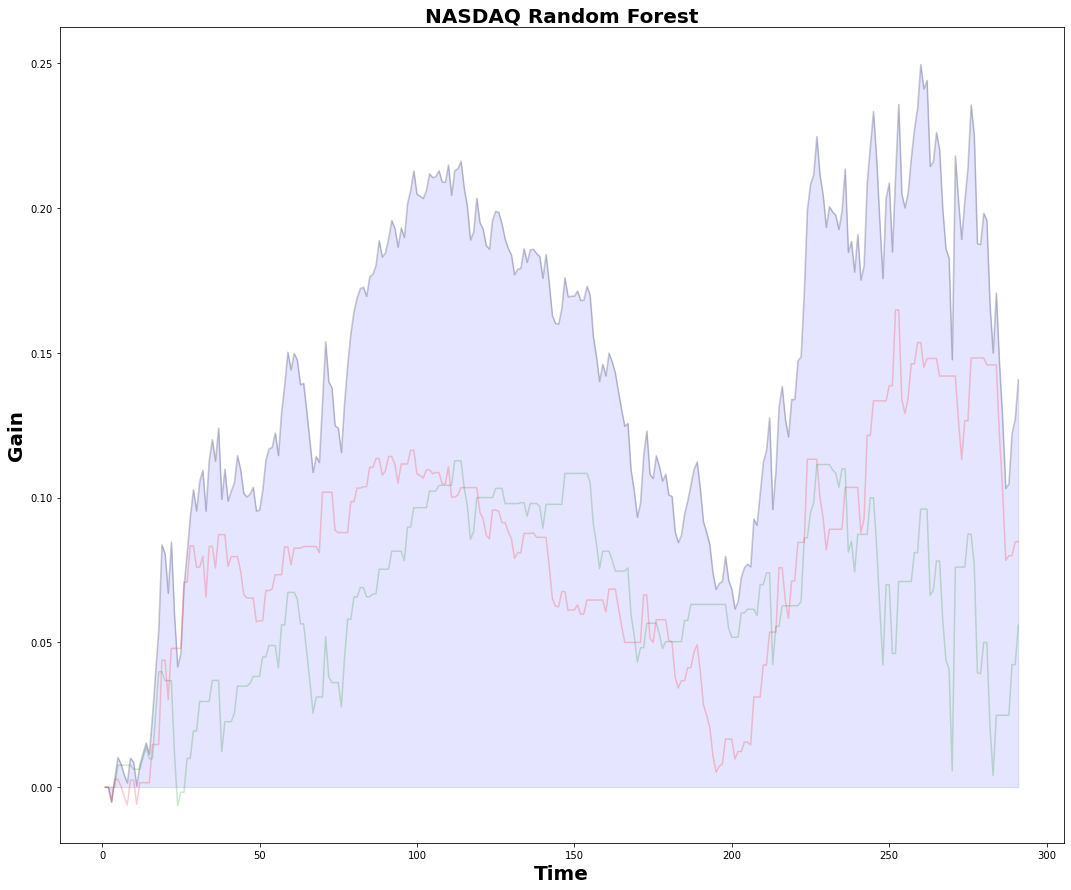

In [197]:
x = np.linspace(1,len(ibm_test.Close),len(ibm_test.Close),dtype='int')
fig = plt.figure(figsize = (18,15))
ax = fig.add_subplot(111)
ax.set_ylabel('Gain',fontweight ='bold',fontsize=20)
ax.set_xlabel('Time',fontweight ='bold',fontsize=20)
ax.set_title('IBM Random Forest',fontweight ='bold',fontsize=20)
plt.plot(x, ibm_test["TotEquity"], alpha=0.2, color='black',linewidth=1.5, label = 'General Equity')
plt.plot(x, ibm_test["LongEquity"], alpha=0.2, color='green',linewidth=1.5, label = 'Long Equity')
plt.plot(x, ibm_test["ShortEquity"], alpha=0.2, color='red',linewidth=1.5, label = 'Short Equity')
ax.fill_between(x, ibm_test["TotEquity"], 0, color='blue', alpha=.1)

x2 = np.linspace(1,len(wti_test.Close),len(wti_test.Close),dtype='int')
fig2 = plt.figure(figsize = (18,15))
ax2 = fig2.add_subplot(111)
ax2.set_ylabel('Gain',fontweight ='bold',fontsize=20)
ax2.set_xlabel('Time',fontweight ='bold',fontsize=20)
ax2.set_title('WTI Random Forest',fontweight ='bold',fontsize=20)
plt.plot(x2, wti_test["TotEquity"], alpha=0.2, color='black',linewidth=1.5, label = 'General Equity')
plt.plot(x2, wti_test["LongEquity"], alpha=0.2, color='green',linewidth=1.5, label = 'Long Equity')
plt.plot(x2, wti_test["ShortEquity"], alpha=0.2, color='red',linewidth=1.5, label = 'Short Equity')
ax2.fill_between(x2, wti_test["TotEquity"], 0, color='blue', alpha=.1)

x3 = np.linspace(1,len(gold_test.Close),len(gold_test.Close),dtype='int')
fig3 = plt.figure(figsize = (18,15))
ax3 = fig3.add_subplot(111)
ax3.set_ylabel('Gain',fontweight ='bold',fontsize=20)
ax3.set_xlabel('Time',fontweight ='bold',fontsize=20)
ax3.set_title('GOLD Random Forest',fontweight ='bold',fontsize=20)
plt.plot(x3, gold_test["TotEquity"], alpha=0.2, color='black',linewidth=1.5, label = 'General Equity')
plt.plot(x3, gold_test["LongEquity"], alpha=0.2, color='green',linewidth=1.5, label = 'Long Equity')
plt.plot(x3, gold_test["ShortEquity"], alpha=0.2, color='red',linewidth=1.5, label = 'Short Equity')
ax2.fill_between(x3, gold_test["TotEquity"], 0, color='blue', alpha=.1)

x4 = np.linspace(1,len(nasdaq_test.Close),len(nasdaq_test.Close),dtype='int')
fig4 = plt.figure(figsize = (18,15))
ax4 = fig4.add_subplot(111)
ax4.set_ylabel('Gain',fontweight ='bold',fontsize=20)
ax4.set_xlabel('Time',fontweight ='bold',fontsize=20)
ax4.set_title('NASDAQ Random Forest',fontweight ='bold',fontsize=20)
plt.plot(x4, nasdaq_test["TotEquity"], alpha=0.2, color='black',linewidth=1.5, label = 'General Equity')
plt.plot(x4, nasdaq_test["LongEquity"], alpha=0.2, color='green',linewidth=1.5, label = 'Long Equity')
plt.plot(x4, nasdaq_test["ShortEquity"], alpha=0.2, color='red',linewidth=1.5, label = 'Short Equity')
ax4.fill_between(x4, nasdaq_test["TotEquity"], 0, color='blue', alpha=.1)

ax.legend()
plt.show()

